In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import holidays
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.backend import square, mean
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, GRU, Embedding

In [3]:
segment_speeds = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/segment-data/60-min-intervals/428389808-60min-260events.csv", sep=";")
wind_speed = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-wind-speed.csv", sep=",")
rain = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-rain-amount.csv", sep=",")
snow_depth = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-snow-depth.csv", sep=",")
temperature = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/weather data/smhi-weather-station-data-temperature.csv", sep=",")

In [4]:
wind_speed = wind_speed.loc[(wind_speed['Datum'] >= "2019-06-04")]
rain = rain.loc[(rain['Datum'] >= "2019-06-04")]
snow_depth = snow_depth.loc[(snow_depth['Datum'] >= "2019-06-04")]
temperature = temperature.loc[(temperature['Datum'] >= "2019-06-04")]

In [5]:
road_events = pd.read_csv("/home/andrehoejmark/Desktop/GitHub/AVG-Speed-Prediction-of-cars-based-on-road-events/data/RoadEvents_SegmentID_428389808.csv", sep=",")

In [6]:
road_events.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Skapad_År', 'Skapad_Månad', 'NAME',
       'EVENT_CODE', 'EVENT_TEXT', 'Location_text', 'Väg', 'Riktning',
       'LANE_MASK', 'CREATION_TIME', 'COMPLETION_TIME', 'START_TIME',
       'END_TIME', 'Note', 'X', 'Y', 'latitude', 'longitude', 'SegmentID'],
      dtype='object')

In [7]:
road_events[['START_TIME', 'EVENT_CODE', 'EVENT_TEXT', 'Väg']]

,START_TIME,EVENT_CODE,EVENT_TEXT,Väg
0,2019-01-05 17:07:51,32,Stillastående fordon,E4
1,2019-01-08 22:35:04,255,Bärgning,E4
2,2019-01-17 01:09:02,255,Bärgning,E4
3,2019-01-17 14:18:15,255,Bärgning,E4
4,2019-01-18 12:28:50,255,Bärgning,E4
...,...,...,...,...
147,2021-08-29 14:20:42,169,Långsam kö,E4
148,2021-09-13 06:58:44,34,Föremål på vägbanan,E4
149,2021-09-16 20:15:26,255,Bärgning,E4
150,2021-11-01 14:46:56,255,Bärgning,E4


In [8]:
segment_speeds.head(5)

,SegmentId,StartTime,EndTime,Speed
0,428389808,2019-06-03 00:00:00,2019-06-03 01:00:00,NaN
1,428389808,2019-06-03 01:00:00,2019-06-03 02:00:00,NaN
2,428389808,2019-06-03 02:00:00,2019-06-03 03:00:00,NaN
3,428389808,2019-06-03 03:00:00,2019-06-03 04:00:00,NaN
4,428389808,2019-06-03 04:00:00,2019-06-03 05:00:00,NaN


In [9]:
wind_speed.head(5)

,Datum,Tid (UTC),Vindriktning,Kvalitet,Vindhastighet,Kvalitet.1
297120,2019-06-04,00:00:00,192.0,G,4.7,G
297121,2019-06-04,01:00:00,204.0,G,5.0,G
297122,2019-06-04,02:00:00,211.0,G,4.8,G
297123,2019-06-04,03:00:00,214.0,G,4.9,G
297124,2019-06-04,04:00:00,231.0,G,6.7,G


In [10]:
rain.head(5)

,Datum,Tid (UTC),Nederbördsmängd,Kvalitet
206305,2019-06-04,00:00:00,0.0,G
206306,2019-06-04,01:00:00,0.0,G
206307,2019-06-04,02:00:00,0.0,G
206308,2019-06-04,03:00:00,0.0,G
206309,2019-06-04,04:00:00,0.0,G


In [11]:
snow_depth.head(5)

,Datum,Tid (UTC),Snödjup,Kvalitet,Markens tillstånd,Kvalitet.1
4731,2019-06-04,06:00:00,0.0,G,0.0,G
4732,2019-06-05,06:00:00,0.0,G,0.0,G
4733,2019-06-06,06:00:00,0.0,G,0.0,G
4734,2019-06-07,06:00:00,0.0,G,0.0,G
4735,2019-06-08,06:00:00,0.0,G,0.0,G


In [12]:
temperature.head(5)

,Datum,Tid (UTC),Lufttemperatur,Kvalitet
284343,2019-06-04,00:00:00,13.7,G
284344,2019-06-04,01:00:00,14.1,G
284345,2019-06-04,02:00:00,14.2,G
284346,2019-06-04,03:00:00,14.3,G
284347,2019-06-04,04:00:00,13.6,G


Removing the first 24 records because the first 24 records are null values for traffic speed

In [13]:
segment_speeds = segment_speeds[24:]

Adding days and hours to the dataset because that could make it easier for it to identify what time instead of receiving a date column which is more complex.

In [14]:
pd.to_datetime(segment_speeds['StartTime'], format="%Y-%m-%d %H:%M:%S")
segment_speeds['hour'] = pd.DatetimeIndex(segment_speeds['StartTime']).hour
segment_speeds['day'] = pd.DatetimeIndex(segment_speeds['StartTime']).dayofyear
segment_speeds['year'] = pd.DatetimeIndex(segment_speeds['StartTime']).year
segment_speeds['day_name'] = pd.DatetimeIndex(segment_speeds['StartTime']).day_name()

In [15]:
dummy1 = pd.get_dummies(segment_speeds['day_name'])

In [16]:
segment_speeds = pd.concat([segment_speeds, dummy1], axis=1).drop('day_name', axis=1)

#### Adding holidays

In [17]:
sweden_holidays = holidays.country_holidays('SE')

In [18]:
holiday = []
 
for date in segment_speeds[['StartTime']].values:
    
    year_month_day = date[0].split(' ')[0]
    
    res = sweden_holidays.get(str(year_month_day))
    
    if res != None and res != "Söndag":
        holiday.append(1)
    else:
        holiday.append(0)

segment_speeds['holiday'] = holiday

#### Interpolation is performed for null values

In [19]:
segment_speeds = segment_speeds.interpolate(method='linear', limit_direction='forward', axis=0)

##### Now we merge the traffic speeds with the weather data and first need to put the segment speeds in same format as the weather data

In [20]:
pd.to_datetime(temperature['Datum'], format="%Y-%m-%d")
pd.to_datetime(temperature['Tid (UTC)'], format="%H:%M:%S")
temperature['hour'] = pd.DatetimeIndex(temperature['Tid (UTC)']).hour
temperature['day'] = pd.DatetimeIndex(temperature['Datum']).dayofyear
temperature['year'] = pd.DatetimeIndex(temperature['Datum']).year

pd.to_datetime(rain['Datum'], format="%Y-%m-%d")
pd.to_datetime(rain['Tid (UTC)'], format="%H:%M:%S")
rain['hour'] = pd.DatetimeIndex(rain['Tid (UTC)']).hour
rain['day'] = pd.DatetimeIndex(rain['Datum']).dayofyear
rain['year'] = pd.DatetimeIndex(rain['Datum']).year

pd.to_datetime(wind_speed['Datum'], format="%Y-%m-%d")
pd.to_datetime(wind_speed['Tid (UTC)'], format="%H:%M:%S")
wind_speed['hour'] = pd.DatetimeIndex(wind_speed['Tid (UTC)']).hour
wind_speed['day'] = pd.DatetimeIndex(wind_speed['Datum']).dayofyear
wind_speed['year'] = pd.DatetimeIndex(wind_speed['Datum']).year

pd.to_datetime(snow_depth['Datum'], format="%Y-%m-%d")
pd.to_datetime(snow_depth['Tid (UTC)'], format="%H:%M:%S")
snow_depth['hour'] = pd.DatetimeIndex(snow_depth['Tid (UTC)']).hour
snow_depth['day'] = pd.DatetimeIndex(snow_depth['Datum']).dayofyear
snow_depth['year'] = pd.DatetimeIndex(snow_depth['Datum']).year

pd.to_datetime(road_events['START_TIME'], format="%Y-%m-%d %H:%M:%S")
road_events['hour'] = pd.DatetimeIndex(road_events['START_TIME']).hour
road_events['day'] = pd.DatetimeIndex(road_events['START_TIME']).dayofyear
road_events['year'] = pd.DatetimeIndex(road_events['START_TIME']).year

In [21]:
road_events[['year']].head()

,year
0,2019
1,2019
2,2019
3,2019
4,2019


In [22]:
road_events[['EVENT_CODE', 'EVENT_TEXT']].values

array([[32, 'Stillastående fordon'],
       [255, 'Bärgning'],
       [255, 'Bärgning'],
       [255, 'Bärgning'],
       [255, 'Bärgning'],
       [35, 'Olycka'],
       [32, 'Stillastående fordon'],
       [32, 'Stillastående fordon'],
       [379, 'Skadat räcke #'],
       [32, 'Stillastående fordon'],
       [32, 'Stillastående fordon'],
       [379, 'Skadat räcke #'],
       [255, 'Bärgning'],
       [34, 'Föremål på vägbanan'],
       [32, 'Stillastående fordon'],
       [35, 'Olycka'],
       [169, 'Långsam kö'],
       [32, 'Stillastående fordon'],
       [32, 'Stillastående fordon'],
       [169, 'Långsam kö'],
       [32, 'Stillastående fordon'],
       [255, 'Bärgning'],
       [35, 'Olycka'],
       [35, 'Olycka'],
       [255, 'Bärgning'],
       [169, 'Långsam kö'],
       [169, 'Långsam kö'],
       [32, 'Stillastående fordon'],
       [169, 'Långsam kö'],
       [32, 'Stillastående fordon'],
       [32, 'Stillastående fordon'],
       [32, 'Stillastående fordon'],
     

##### A left join is done to keep the values from the old data because for example snow_depth only have records certain days and then we could fill the NaN values from the left join with some approximation

In [23]:
#segment_speeds_weather = segment_speeds[['SegmentId', 'hour', 'day', 'year', 'Speed']]
segment_speeds_weather = segment_speeds

segment_speeds_weather = pd.merge(segment_speeds[['SegmentId', 'StartTime', 'hour', 'day', 'year', 'Speed', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Friday', 'holiday']], temperature[['Lufttemperatur', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
segment_speeds_weather = pd.merge(segment_speeds_weather, road_events[['EVENT_CODE', 'EVENT_TEXT', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
segment_speeds_weather = pd.merge(segment_speeds_weather, rain[['Nederbördsmängd', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
segment_speeds_weather = pd.merge(segment_speeds_weather, wind_speed[['Vindhastighet', 'hour', 'day', 'year']], on=['day', 'year', 'hour'], how='left')
segment_speeds_weather = pd.merge(segment_speeds_weather, snow_depth[['Snödjup', 'hour', 'day', 'year']], on=['day', 'year'], how='left')


segment_speeds_weather.rename(columns = {'hour_x':'hour'}, inplace = True)
segment_speeds_weather.drop('hour_y', axis=1, inplace=True)

#### Adding temperature based on last known temperature when missing data

In [24]:
temp = []

last_known_temperatuer = None
for temperature in segment_speeds_weather[['Lufttemperatur']].values:


    #print(temperature[0], type(temperature[0]))
    if math.isnan(temperature[0]):
        
        if last_known_temperatuer == None:
            print("The first NaN values has no previous value to put there")
        else:
            temp.append(last_known_temperatuer)
    else:
        last_known_temperatuer = temperature[0]
        temp.append(temperature[0])
        

segment_speeds_weather['Temperature-with-last-known-value-on-nan'] = temp

#### Adding AVG wind speed for NaN Values

In [25]:
avg_wind_speed = segment_speeds_weather['Vindhastighet'].mean()

wind_speeds = []

for wind_speed in segment_speeds_weather[['Vindhastighet']].values:
    
    if math.isnan(wind_speed[0]):
        wind_speeds.append(avg_wind_speed)
    else:
        wind_speeds.append(wind_speed[0])
        

segment_speeds_weather['Wind-speed-avg-when-nan'] = wind_speeds

#### Handle NAN values

In [26]:
segment_speeds_weather['Lufttemperatur'] = segment_speeds_weather['Lufttemperatur'].interpolate(method='linear', limit_direction='forward', axis=0)
segment_speeds_weather['Nederbördsmängd'] = segment_speeds_weather['Nederbördsmängd'].interpolate(method='linear', limit_direction='forward', axis=0)
segment_speeds_weather['Vindhastighet'] = segment_speeds_weather['Vindhastighet'].interpolate(method='linear', limit_direction='forward', axis=0)
segment_speeds_weather['Snödjup'] = segment_speeds_weather['Snödjup'].fillna(0)
segment_speeds_weather['EVENT_CODE'] = segment_speeds_weather['EVENT_CODE'].fillna(0)
segment_speeds_weather['EVENT_TEXT'] = segment_speeds_weather['EVENT_TEXT'].fillna(0)

In [28]:
segment_speeds_weather.isna().sum()

SegmentId                                   0
StartTime                                   0
hour                                        0
day                                         0
year                                        0
Speed                                       0
Monday                                      0
Saturday                                    0
Sunday                                      0
Thursday                                    0
Tuesday                                     0
Wednesday                                   0
Friday                                      0
holiday                                     0
Lufttemperatur                              0
EVENT_CODE                                  0
EVENT_TEXT                                  0
Nederbördsmängd                             0
Vindhastighet                               0
Snödjup                                     0
Temperature-with-last-known-value-on-nan    0
Wind-speed-avg-when-nan           

#### Make it into CSV for us to use

In [29]:
segment_speeds_weather.to_csv("segment_speeds_weather_road_events.csv", sep=",")

In [30]:
segment_speeds_weather.head(5)

,SegmentId,StartTime,hour,day,year,Speed,Monday,Saturday,Sunday,Thursday,...,Friday,holiday,Lufttemperatur,EVENT_CODE,EVENT_TEXT,Nederbördsmängd,Vindhastighet,Snödjup,Temperature-with-last-known-value-on-nan,Wind-speed-avg-when-nan
0,428389808,2019-06-04 00:00:00,0,155,2019,116.150000,0,0,0,0,...,0,0,13.7,0.0,0,0.0,4.7,0.0,13.7,4.7
1,428389808,2019-06-04 01:00:00,1,155,2019,94.033333,0,0,0,0,...,0,0,14.1,0.0,0,0.0,5.0,0.0,14.1,5.0
2,428389808,2019-06-04 02:00:00,2,155,2019,93.983333,0,0,0,0,...,0,0,14.2,0.0,0,0.0,4.8,0.0,14.2,4.8
3,428389808,2019-06-04 03:00:00,3,155,2019,83.466667,0,0,0,0,...,0,0,14.3,0.0,0,0.0,4.9,0.0,14.3,4.9
4,428389808,2019-06-04 04:00:00,4,155,2019,86.250000,0,0,0,0,...,0,0,13.6,0.0,0,0.0,6.7,0.0,13.6,6.7


In [31]:
#segment_speeds_weather.loc[(segment_speeds_weather['EVENT_CODE'] == 2019) & (segment_speeds_weather['Speed'] < 70)]

In [39]:
filt = segment_speeds_weather.loc[(segment_speeds_weather['EVENT_CODE'] == 35)]

In [40]:
filt

,SegmentId,StartTime,hour,day,year,Speed,Monday,Saturday,Sunday,Thursday,...,Friday,holiday,Lufttemperatur,EVENT_CODE,EVENT_TEXT,Nederbördsmängd,Vindhastighet,Snödjup,Temperature-with-last-known-value-on-nan,Wind-speed-avg-when-nan
1816,428389808,2019-08-18 15:00:00,15,230,2019,107.816667,0,0,1,0,...,0,0,17.8,35.0,Olycka,0.4,3.5,0.00,17.8,3.5
5901,428389808,2020-02-04 17:00:00,17,35,2020,85.483333,0,0,0,0,...,0,0,-1.6,35.0,Olycka,0.0,3.3,0.00,-1.6,3.3
5917,428389808,2020-02-05 09:00:00,9,36,2020,101.733333,0,0,0,0,...,0,0,-0.6,35.0,Olycka,0.0,9.3,0.00,-0.6,9.3
6450,428389808,2020-02-27 12:00:00,12,58,2020,95.233333,0,0,0,1,...,0,0,0.2,35.0,Olycka,0.0,7.3,0.00,0.2,7.3
11880,428389808,2020-10-15 17:00:00,17,289,2020,85.650000,0,0,0,1,...,0,0,9.4,35.0,Olycka,0.0,1.7,0.00,9.4,1.7
12260,428389808,2020-10-31 13:00:00,13,305,2020,65.350000,0,1,0,0,...,0,1,7.8,35.0,Olycka,0.0,3.1,0.00,7.8,3.1
14226,428389808,2021-01-21 08:00:00,8,21,2021,75.883333,0,0,0,1,...,0,0,2.3,35.0,Olycka,0.9,6.0,0.29,2.3,6.0
14227,428389808,2021-01-21 09:00:00,9,21,2021,82.166667,0,0,0,1,...,0,0,2.3,35.0,Olycka,0.1,6.0,0.29,2.3,6.0


In [43]:
filt2 = segment_speeds_weather.loc[(segment_speeds_weather['StartTime'] > "2020-02-03 17:00:00") & (segment_speeds_weather['StartTime'] < "2020-02-05 17:00:00")]

In [44]:
filt2

,SegmentId,StartTime,hour,day,year,Speed,Monday,Saturday,Sunday,Thursday,...,Friday,holiday,Lufttemperatur,EVENT_CODE,EVENT_TEXT,Nederbördsmängd,Vindhastighet,Snödjup,Temperature-with-last-known-value-on-nan,Wind-speed-avg-when-nan
5878,428389808,2020-02-03 18:00:00,18,34,2020,96.033333,1,0,0,0,...,0,0,0.7,0.0,0,0.0,5.1,0.0,0.7,5.1
5879,428389808,2020-02-03 19:00:00,19,34,2020,78.483333,1,0,0,0,...,0,0,0.6,0.0,0,0.0,3.3,0.0,0.6,3.3
5880,428389808,2020-02-03 20:00:00,20,34,2020,80.216667,1,0,0,0,...,0,0,-0.1,0.0,0,0.0,4.1,0.0,-0.1,4.1
5881,428389808,2020-02-03 21:00:00,21,34,2020,106.516667,1,0,0,0,...,0,0,0.0,0.0,0,0.0,3.8,0.0,0.0,3.8
5882,428389808,2020-02-03 22:00:00,22,34,2020,94.983333,1,0,0,0,...,0,0,0.0,0.0,0,0.0,3.9,0.0,0.0,3.9
5883,428389808,2020-02-03 23:00:00,23,34,2020,106.533333,1,0,0,0,...,0,0,0.2,0.0,0,0.0,2.0,0.0,0.2,2.0
5884,428389808,2020-02-04 00:00:00,0,35,2020,90.966667,0,0,0,0,...,0,0,0.1,0.0,0,0.0,1.9,0.0,0.1,1.9
5885,428389808,2020-02-04 01:00:00,1,35,2020,91.966667,0,0,0,0,...,0,0,0.2,0.0,0,0.0,2.2,0.0,0.2,2.2
5886,428389808,2020-02-04 02:00:00,2,35,2020,92.000000,0,0,0,0,...,0,0,0.0,0.0,0,0.0,3.0,0.0,0.0,3.0
5887,428389808,2020-02-04 03:00:00,3,35,2020,92.000000,0,0,0,0,...,0,0,0.1,0.0,0,0.0,2.5,0.0,0.1,2.5


<AxesSubplot:xlabel='StartTime'>

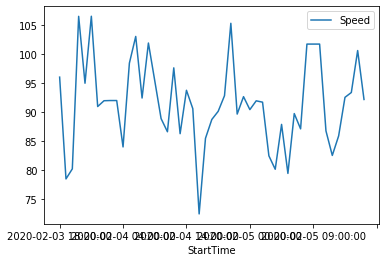

In [46]:
filt2.plot(x="StartTime", y="Speed")